In [155]:
import cv2
import numpy as np
import os


video_folder = "/home/persie/Videos/mokap/"
session_id = os.listdir(video_folder)
video_file = []
for folder in session_id:
    files = os.listdir(os.path.join(video_folder, folder))
    for file in files:
        video_file.append(os.path.join(video_folder, folder, file))

cap = cv2.VideoCapture(video_file[33])
cap.set(cv2.CAP_PROP_POS_FRAMES, 134)
ret, frame = cap.read()
clear_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)


def draw_circle(event, x, y, flags, param):
    #Because of the use of global variables, they must be defined before using them, outside of any functions
    global radius, text_image, mask
    if flags == cv2.EVENT_FLAG_SHIFTKEY:
        cv2.circle(mask, (x, y), radius, (0, 0, 0), -1)
    if flags == cv2.EVENT_FLAG_LBUTTON:
        cv2.circle(mask, (x, y), radius, (255, 255, 255), -1)

    text_image = cv2.rectangle(text_image, (0, 70), (35, 40), (255, 255, 255), -1)
    text_image = cv2.putText(text_image, str(radius), (0, 65), cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.8,
                             color=(0, 0, 255), thickness=2)


#Select frame with object in
cap = cv2.VideoCapture(video_file[33])
cap.set(cv2.CAP_PROP_POS_FRAMES, 1507)
ret, frame = cap.read()
object_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
# Run the mask creation code
text_image = object_frame
mask = np.zeros_like(object_frame, np.uint8)
# Set the initial circle radius
radius = 50
line_1 = "Click with the left mouse button to add, double click to remove"
line_2 = "Up = radius + 5,"
line_3 = "Down = radius - 5"
text_image = cv2.putText(text_image, line_1, (10, 10), cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(0, 255, 0),
                         thickness=2)
text_image = cv2.putText(text_image, line_2, (10, 22), cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(0, 255, 0),
                         thickness=2)
text_image = cv2.putText(text_image, line_3, (10, 34), cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(0, 255, 0),
                         thickness=2)
combined_image = cv2.bitwise_or(text_image, mask)
cv2.namedWindow('Mask On Frame')
cv2.imshow('Mask On Frame', combined_image)
cv2.setMouseCallback('Mask On Frame', draw_circle)

while (1):
    combined_image = cv2.bitwise_or(text_image, mask)
    cv2.imshow('Mask On Frame', combined_image)
    cv2.imshow('Mask', mask)
    k = cv2.waitKey(20) & 0xFF
    if k == ord("q"):
        break
    if k == 82:
        #upkey
        radius = radius + 5
    if k == 84:
        #downkey
        radius = radius - 5

cap.release()
cv2.destroyAllWindows()
object_mask = mask

In [56]:
contours,hierarchy = cv2.findContours(object_mask, 1, 2)
cnt = contours[0]
x,y,w,h = cv2.boundingRect(cnt)
#box = np.int(box)
img = object_mask.copy()

cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),10)
cv2.imshow('img', img[y:y+h,x:x+w])
cv2.waitKey(0)
cv2.destroyAllWindows()

In [121]:
#Select frame with object in
cap = cv2.VideoCapture(video_file[33])
cap.set(cv2.CAP_PROP_POS_FRAMES, 2907)
ret, frame = cap.read()
new_object_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

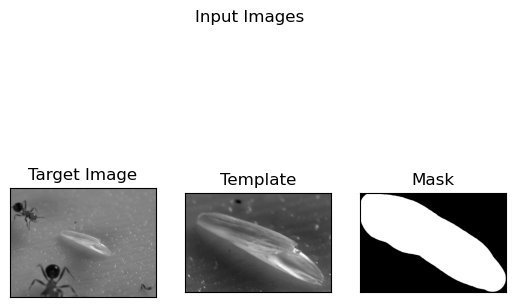

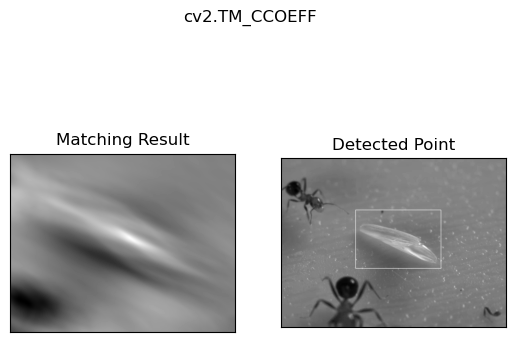

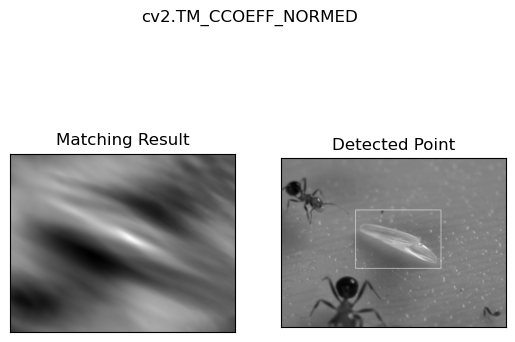

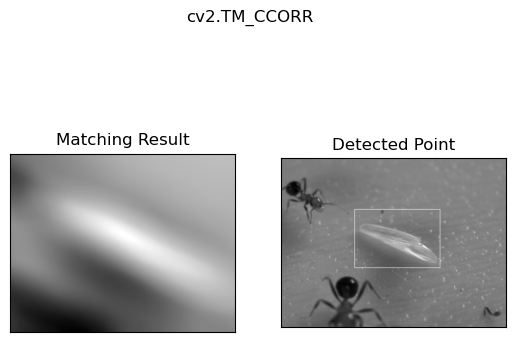

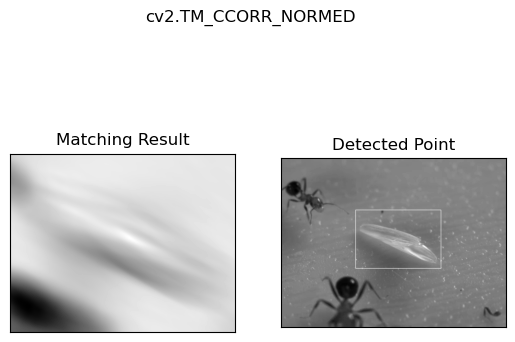

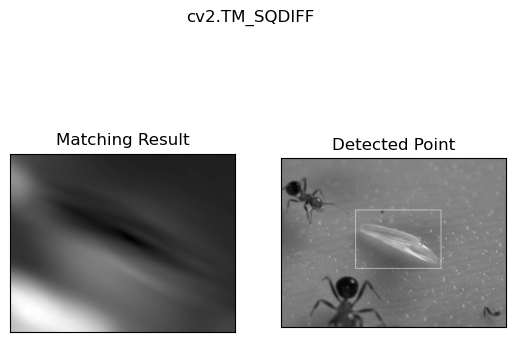

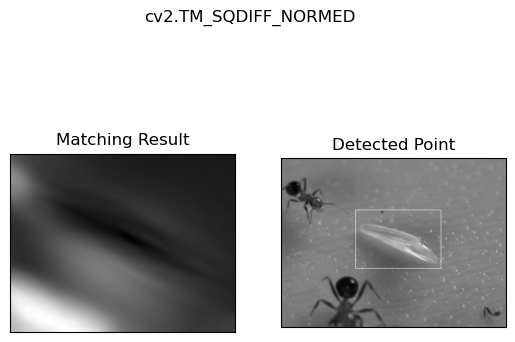

In [68]:
import matplotlib.pyplot as plt
img = new_object_frame.copy()
img2 = img.copy()
template = object_frame[y:y+h,x:x+w]
cropped_mask = mask[y:y+h,x:x+w]

plt.subplot(131),plt.imshow(img,cmap = 'gray')
plt.title('Target Image'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(template,cmap = 'gray')
plt.title('Template'), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(cropped_mask,cmap = 'gray')
plt.title('Mask'), plt.xticks([]), plt.yticks([])
plt.suptitle("Input Images")
plt.show()

#w, h = template.shape[::-1]
# All the 6 methods for comparison in a list
methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR',
            'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED'] # Best seems to be TM_CCORR
for meth in methods:
    img = img2.copy()
    method = eval(meth)
    # Apply template Matching
    res = cv2.matchTemplate(img,template,method, mask=object_mask)
    #print(res)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    #print(min_val, max_val, min_loc, max_loc)
    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv2.rectangle(img,top_left, bottom_right, 255, 2)
    plt.subplot(121),plt.imshow(res,cmap = 'gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(img,cmap = 'gray')
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    plt.suptitle(meth)
    plt.show()

# Template Tracking Test

In [146]:
#Find the moment of the reduced mask
def find_centre(contours):
    # Calculate image moments of the detected contour
    M = cv2.moments(contours[0])

    # Print center (debugging):
    x = round(M['m10'] / M['m00'])
    y = round(M['m01'] / M['m00'])

    return x, y

In [138]:
def find_convex_hull(image, mask):
    #Attempt to refine the mask
    #Create an image where every pixel outside of the mask is set to the mean value of the image outside the mask
    thresh = cv2.mean(image, mask=cv2.bitwise_not(mask))[0]
    average_bg = cv2.bitwise_and(cv2.bitwise_not(mask), thresh)
    masked_seed = cv2.bitwise_and(image, image, mask=mask)
    average_image = cv2.bitwise_xor(masked_seed, average_bg)
    
    #Blur image and apply adaptive thresholding
    blur = cv2.GaussianBlur(average_image,(7,7),0)
    _, thresh_image = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    blur_thresh = cv2.blur(thresh_image, (3,3))
    contours,_ = cv2.findContours(blur_thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    #Create an empty array of edges to be filled
    edges = np.empty((0,2), dtype=np.uint8)
    
    #Compile all contours in image but ignore lines that are shorter than the threshold
    for i in range(len(contours)):
        if len(contours[i]) > 15:
            edges = np.concatenate([edges, *contours[i]])
    
    convex_hull = cv2.convexHull(edges)
    new_mask  = np.zeros_like(image, dtype=np.uint8)
    cv2.drawContours(new_mask, [convex_hull], -1, (255,255,255), -1)
    
    x,y = find_centre([convex_hull]) #This is called 39 times and I don't know how to stop it
    
    return convex_hull[0], new_mask, x, y

In [145]:
def find_bounding_box(contours, image, mask):    
    x,y,w,h = cv2.boundingRect(contours)
    template = image[y:y+h,x:x+w]
    cropped_mask = mask[y:y+h,x:x+w]
    return template, cropped_mask
    

In [144]:
def match_template(image, template, mask):
    # Apply template Matching
    res = cv2.matchTemplate(image,template, cv2.TM_CCORR, mask=mask)
    _, _, _, max_loc = cv2.minMaxLoc(res)
    #top_left = max_loc
    x,y = max_loc
    return x,y

In [141]:
def transform_mask(mask, old_x, old_y, new_x, new_y):
    dx = new_x - old_x
    dy = new_y - old_y
    T = np.float32([[1,0,dx],[0,1,dy]])
    new_mask = cv2.warpAffine(mask,T, (mask.shape[1], mask.shape[0]))
    
    return new_mask

In [156]:
# Set the initial frame and mask
initial_frame = 1507

convex_hull, convex_mask, x, y = find_convex_hull(object_frame, object_mask)
#Crop the mask for the first time
template, cropped_mask = find_bounding_box(convex_hull, object_frame, convex_mask)

cap = cv2.VideoCapture(video_file[33])
cap.set(cv2.CAP_PROP_POS_FRAMES, initial_frame)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert current frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    #Find the pixel co-ordinates of the new match
    new_x,new_y = match_template(gray, template, cropped_mask)
    
    #Move the mask to the new match
    new_mask = transform_mask(mask, x, y, new_x, new_y)
    cv2.imshow('New Mask', new_mask)
    #Inflate the mask to allow for movement
    new_mask = cv2.dilate(new_mask, None, iterations=2)
    cv2.imshow('New Mask (D)', new_mask)
    #Find the convex hull
    convex_hull, convex_mask, _, _ = find_convex_hull(gray, new_mask)
    cv2.imshow('Convex Mask', convex_mask)
    #Crop the mask
    new_template, cropped_mask = find_bounding_box(convex_hull, gray, convex_mask)
        
    #Plot the convex hull on a temporary image frame
    new_f = np.zeros_like(gray, np.uint8)
    cv2.drawContours(new_f, [convex_hull], 0, (255,255,255), -1)
    
    cv2.imshow('Output', gray)
    cv2.imshow('Contour', new_f)
    
    #Reset held values
    x = new_x
    y = new_y
    template = new_template
    mask = convex_mask

    if cv2.waitKey(30) & 0xFF == ord('q'):
        break


cap.release()
cv2.destroyAllWindows()

In [ ]:
#Find initial moment
contours, hierarchy = cv2.findContours(object_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
cnt = contours[0]
x,y,w,h = cv2.boundingRect(cnt)

#Attempt to refine the mask
thresh = cv2.mean(object_frame, mask=cv2.bitwise_not(object_mask))[0]
average_bg = cv2.bitwise_and(cv2.bitwise_not(object_mask), thresh)
masked_seed = cv2.bitwise_and(object_frame, object_frame, mask=object_mask)
thresh_bg = np.ones_like(object_frame) * np.ceil(thresh).astype(np.uint8)
average_image = cv2.bitwise_xor(masked_seed, average_bg)

# Otsu's thresholding after Gaussian filtering
blur = cv2.GaussianBlur(average_image, (7, 7), 0)
ret3, th3 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
cv2.imshow("blended", average_image)
cv2.imshow("th3", th3)

src = th3.copy()

# Create Window
source_window = 'Source'
cv2.namedWindow(source_window, cv2.WINDOW_NORMAL)

cv2.imshow('Source', src)
color = []
for n in range(0, 20):
    color.append((rng.randint(0, 256), rng.randint(0, 256), rng.randint(0, 256)))

    blur_fg = cv2.blur(src, (3, 3))
    # Find contours
    contours, _ = cv2.findContours(blur_fg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    edges = np.empty((0, 2), dtype=np.uint8)

    #Find the overall contour
    for i in range(len(contours)):
        if len(contours[i]) > 15:
            edges = np.concatenate([edges, *contours[i]])

    convex_hull = cv2.convexHull(edges)
    drawing = np.zeros_like(src, dtype=np.uint8)
    new_mask = np.zeros_like(src, dtype=np.uint8)
    new_edge = object_frame.copy()
    cv2.drawContours(drawing, [convex_hull], -1, color[0], 3)
    cv2.drawContours(new_edge, [convex_hull], -1, color[0], 3)
    cv2.drawContours(new_mask, [convex_hull], -1, (255, 255, 255), -1)

    x, y = find_centre([convex_hull])  #This is called 39 times and I don't know how to stop it
    cv2.circle(new_mask, (x, y), 5, (0, 255, 0), -1)

while True:
    # Show in a window
    cv2.imshow('Contours', drawing)
    cv2.imshow('New', new_edge)
    cv2.imshow('New Mask', new_mask)

    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()




#Apply an affine warp to the mask
affine = cv2.getAffineTransform([cv2.KeyPoint[0, 0], [0, 5], [5, 0]], [[45, 45], [45, 50], [50, 45]])

out = cv2.warpAffine(new_edge, affine, (new_mask.shape[1], new_mask.shape[0]))

while True:
    cv2.imshow('New Mask', new_mask)
    cv2.imshow('Transformed Mask', out)

    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()




In [ ]:
cap.release()
cv2.destroyAllWindows()
